In [1]:
import json
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy.stats import mannwhitneyu, brunnermunzel

In [34]:
data = []
with open('data/NQ-baselinescore-gpt35.json') as f:
    data = json.load(f)
    #for line in f:
    #    data.append(json.loads(line))
# Ainf - Asup
#data = [x for x in data if x['ainf'] == 1 or x['asup'] == 1]
y_true = [x['golden_judge'] for x in data]
print(len(y_true))

15045


In [35]:
def score_chain_info_assum(x):
    score = 100000
    if x['ainf'] == 0 and x['asup'] == 0:
        return -score
    if not x['chains']:
        return score
    for chain in x['chains']:
        steps = chain.split('\n')
        chain_score = 10 * len(steps)
        for s in steps:
            if '[[info]]' in s.lower():
                chain_score += 3
            if '[[assumption]]' in s.lower() or '(assumption)' in s.lower():
                chain_score += 5
        if chain_score < score:
            score = chain_score
        #score += chain_score
    score = -score
    return score


def score_info_assum(x):
    score = 100000
    if x['ainf'] == 0 and x['asup'] == 0:
        return -score
    if not x['chains']:
        return score
    for chain in x['chains']:
        steps = chain.split('\n')
        chain_score = 0
        for s in steps:
            if '[[info]]' in s.lower():
                chain_score += 3
            if '[[assumption]]' in s.lower() or '(assumption)' in s.lower():
                chain_score += 5
        if chain_score < score:
            score = chain_score
        #score += chain_score
    score = -score
    return score


def score_chain_only(x):
    score = 100000
    if x['ainf'] == 0 and x['asup'] == 0:
        return -score
    if not x['chains']:
        return score
    for chain in x['chains']:
        steps = chain.split('\n')
        chain_score = 10 * len(steps)
        if chain_score < score:
            score = chain_score
        #score += chain_score
    score = -score
    return score

def score_gpt35(x):
    if x['asup'] == 0 and x['ainf'] == 0:
        return -6
    if not x['scores']:
        return 0
    for score in x['scores']:
        # use regex to find integers in the string
        score = re.findall(r'\d+', score)
        if score:
            score = int(score[0])
            if score < 1 or score > 5:
                return -3
            return -score
    return -3

def score_baseline(x):
    if x['asup'] == 0 and x['ainf'] == 0:
        return -6
    if str(x['baseline_score']) == "-1":
        return 0
    text = x['baseline_score']
    for sc in range(1, 6):
        if str(sc) in text:
            return -sc
    else:
        return -3

In [37]:
#y_scores_1 = [score_chain_info_assum(x) for x in data]
#y_scores_2 = [score_chain_only(x) for x in data]
#y_scores_3 = [score_info_assum(x) for x in data]
#y_scores_4 = [score_gpt35(x) for x in data]
y_scores_5 = [score_baseline(x) for x in data]

#print(metrics.roc_auc_score(y_true, y_scores_1))
#print(metrics.roc_auc_score(y_true, y_scores_2))
#print(metrics.roc_auc_score(y_true, y_scores_3))
print(metrics.roc_auc_score(y_true, y_scores_5))

#disp = metrics.RocCurveDisplay.from_predictions(y_true, y_scores_1, name='CIA')
#disp = metrics.RocCurveDisplay.from_predictions(y_true, y_scores_2, name='C')
#disp = metrics.RocCurveDisplay.from_predictions(y_true, y_scores_3, name='gpt35')
#disp = metrics.RocCurveDisplay.from_predictions(y_true, y_scores_4, name='baseline')

0.8827224333166754


In [8]:
y_scores = y_scores_4
plot_df = []
for y_score, y_t in zip(y_scores, y_true):
    plot_df.append({'score': y_score, 'label': f'y_true={y_t}'})
plot_df = pd.DataFrame(plot_df)

<AxesSubplot:xlabel='score', ylabel='label'>

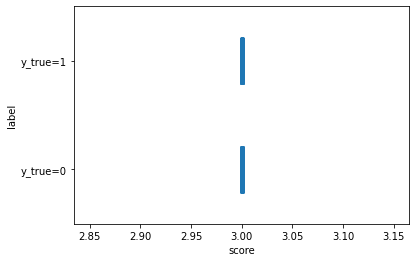

In [12]:
sns.stripplot(plot_df, x='score', y='label', jitter=0.2)

In [9]:
y_true_scores = plot_df[plot_df['label'] == 'y_true=1']['score']
y_false_scores = plot_df[plot_df['label'] == 'y_true=0']['score']
print(mannwhitneyu(y_true_scores, y_false_scores, alternative='greater'))
print(brunnermunzel(y_true_scores, y_false_scores, alternative='greater'))

MannwhitneyuResult(statistic=171612.5, pvalue=1.2655979603115993e-31)
BrunnerMunzelResult(statistic=-13.035929984057034, pvalue=3.182976347341599e-36)
